# **Music Recommendation System**

## Objective

To construct a Music Recommendation System using the Nearest Neighbor Algorithm, leveraging content-based filtering. The recommendation system should be able to provide personalized music recommendations to users based on their preferences and similarities between songs.

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import plotly.graph_objects as go

from kneed import KneeLocator
from sklearn.preprocessing import MinMaxScaler
from scipy.sparse import csr_matrix

from sklearn.neighbors import  NearestNeighbors
from sklearn.cluster import KMeans

## 1. Data Collection

The data was collected with the help of [exportify](https://github.com/watsonbox/exportify).

Alternatively, the data could also be scraped off Spotify using the [Spotipy](https://spotipy.readthedocs.io/en/2.22.1/) library.

In [2]:
df = pd.read_csv('datasets/biggest_playlist_ever.csv', on_bad_lines='warn')

df

,Spotify ID,Artist IDs,Track Name,Album Name,Artist Name(s),Release Date,Duration (ms),Popularity,Added By,Added At,...,Key,Loudness,Mode,Speechiness,Acousticness,Instrumentalness,Liveness,Valence,Tempo,Time Signature
0,7dS5EaCoMnN7DzlpT6aRn2,2FXC3k01G6Gw61bmprjgqS,Take Me To Church,Hozier (Deluxe),Hozier,2014-05-20,241688,0,spotify:user:1130225252,2017-06-09T17:34:13Z,...,4,-5.303,0,0.0464,0.63400,0.000000,0.116,0.437,128.945,4
1,2V4bv1fNWfTcyRJKmej6Sj,"2KsP6tYLJlTBvSUxnwlVWa,1Bo8Afb2Qbjs4x6kJHyjle",Cooler Than Me - Single Mix,31 Minutes to Takeoff,"Mike Posner,Gigamesh",2010-08-09,213293,79,spotify:user:1130225252,2017-06-29T20:42:16Z,...,7,-4.630,0,0.0474,0.17900,0.000000,0.689,0.625,129.965,4
2,7KA4W4McWYRpgf0fWsJZWB,"4V8LLVI7PbaPR0K2TGSxFF,1U1el3k54VvEUzo3ybLPlM",See You Again (feat. Kali Uchis),Flower Boy,"Tyler, The Creator,Kali Uchis",2017-07-21,180386,89,spotify:user:1130225252,2018-07-19T15:34:54Z,...,6,-9.222,1,0.0959,0.37100,0.000007,0.109,0.620,78.558,4
3,3gbBpTdY8lnQwqxNCcf795,7EQ0qTo7fWT7DPxmxtSYEc,Pompeii,Bad Blood,Bastille,2013-01-01,214147,73,spotify:user:1130225252,2016-07-05T18:32:51Z,...,9,-6.383,1,0.0407,0.07550,0.000000,0.271,0.571,127.435,4
4,3ZFTkvIE7kyPt6Nu3PEa7V,"0EmeFodog0BfCgMzAIvKQp,7aBzpmFXB4WWpPl2F7RjBe",Hips Don't Lie (feat. Wyclef Jean),"Oral Fixation, Vol. 2 (Expanded Edition)","Shakira,Wyclef Jean",2005-11-28,218093,87,spotify:user:1130225252,2016-07-05T18:39:38Z,...,10,-5.892,0,0.0707,0.28400,0.000000,0.405,0.758,100.024,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5289,4Zcz6saEkOII3PlXd9gN3o,6CwfuxIqcltXDGjfZsMd9A,Hermit the Frog,The Family Jewels,MARINA,2009-07-15,215960,67,spotify:user:1130225252,2021-06-16T11:00:52Z,...,0,-4.545,1,0.0312,0.24300,0.000000,0.199,0.487,122.034,4
5290,61KpQadow081I2AsbeLcsb,1McMsnEElThX1knmY4oliG,deja vu,deja vu,Olivia Rodrigo,2021-04-01,215507,16,spotify:user:1130225252,2021-06-16T11:00:59Z,...,9,-7.236,1,0.1160,0.59300,0.000011,0.341,0.172,181.088,4
5291,5yorXJWdBan1Vlh116ZtQ7,6veh5zbFpm31XsPdjBgPER,WHOLE LOTTA MONEY,FOR CERTAIN,BIA,2020-12-11,156005,57,spotify:user:1130225252,2021-06-16T11:01:04Z,...,1,-5.019,1,0.3680,0.09040,0.000000,0.325,0.441,81.008,4
5292,11ZulcYY4lowvcQm4oe3VJ,"3PyJHH2wyfQK3WZrk9rpmP,6lay1nwbE6hTx1jivysUAL",Slumber Party (feat. Princess Nokia),DEMIDEVIL,"Ashnikko,Princess Nokia",2021-01-15,178404,73,spotify:user:1130225252,2021-06-16T11:01:10Z,...,11,-8.981,0,0.0795,0.00151,0.000039,0.101,0.563,105.012,4


## 2. Data Preprocessing

### 2.1 Dropping Undesired Columns

The code below removes the columns labeled **Artist IDs**, **Added By**, and **Added At** from the DataFrame **df**. The `axis=1` parameter specifies that the operation is performed along columns, and `inplace=True` ensures that the changes are applied to the DataFrame **df** itself rather than creating a new DataFrame.

In [3]:
df.drop(['Artist IDs', 'Added By', 'Added At'], axis = 1, inplace = True)

df

,Spotify ID,Track Name,Album Name,Artist Name(s),Release Date,Duration (ms),Popularity,Genres,Danceability,Energy,Key,Loudness,Mode,Speechiness,Acousticness,Instrumentalness,Liveness,Valence,Tempo,Time Signature
0,7dS5EaCoMnN7DzlpT6aRn2,Take Me To Church,Hozier (Deluxe),Hozier,2014-05-20,241688,0,"irish singer-songwriter,modern rock,pov: indie",0.566,0.664,4,-5.303,0,0.0464,0.63400,0.000000,0.116,0.437,128.945,4
1,2V4bv1fNWfTcyRJKmej6Sj,Cooler Than Me - Single Mix,31 Minutes to Takeoff,"Mike Posner,Gigamesh",2010-08-09,213293,79,"dance pop,pop,pop dance,pop rap,filter house,n...",0.768,0.820,7,-4.630,0,0.0474,0.17900,0.000000,0.689,0.625,129.965,4
2,7KA4W4McWYRpgf0fWsJZWB,See You Again (feat. Kali Uchis),Flower Boy,"Tyler, The Creator,Kali Uchis",2017-07-21,180386,89,"hip hop,rap,colombian pop",0.558,0.559,6,-9.222,1,0.0959,0.37100,0.000007,0.109,0.620,78.558,4
3,3gbBpTdY8lnQwqxNCcf795,Pompeii,Bad Blood,Bastille,2013-01-01,214147,73,"metropopolis,modern rock,pop",0.679,0.715,9,-6.383,1,0.0407,0.07550,0.000000,0.271,0.571,127.435,4
4,3ZFTkvIE7kyPt6Nu3PEa7V,Hips Don't Lie (feat. Wyclef Jean),"Oral Fixation, Vol. 2 (Expanded Edition)","Shakira,Wyclef Jean",2005-11-28,218093,87,"colombian pop,dance pop,latin pop,pop,rap kreyol",0.778,0.824,10,-5.892,0,0.0707,0.28400,0.000000,0.405,0.758,100.024,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5289,4Zcz6saEkOII3PlXd9gN3o,Hermit the Frog,The Family Jewels,MARINA,2009-07-15,215960,67,"metropopolis,pop,pov: indie,uk alternative pop",0.609,0.679,0,-4.545,1,0.0312,0.24300,0.000000,0.199,0.487,122.034,4
5290,61KpQadow081I2AsbeLcsb,deja vu,deja vu,Olivia Rodrigo,2021-04-01,215507,16,pop,0.439,0.610,9,-7.236,1,0.1160,0.59300,0.000011,0.341,0.172,181.088,4
5291,5yorXJWdBan1Vlh116ZtQ7,WHOLE LOTTA MONEY,FOR CERTAIN,BIA,2020-12-11,156005,57,"rap latina,trap queen",0.897,0.371,1,-5.019,1,0.3680,0.09040,0.000000,0.325,0.441,81.008,4
5292,11ZulcYY4lowvcQm4oe3VJ,Slumber Party (feat. Princess Nokia),DEMIDEVIL,"Ashnikko,Princess Nokia",2021-01-15,178404,73,"alt z,escape room,alternative r&b,lgbtq+ hip h...",0.964,0.398,11,-8.981,0,0.0795,0.00151,0.000039,0.101,0.563,105.012,4


## 2.2 Additional Pre-Processing

In [4]:
df = df[['Track Name', 'Album Name', 'Artist Name(s)', 'Release Date', 'Popularity', 'Duration (ms)', 'Spotify ID', 'Acousticness', 'Danceability', 'Energy', 'Instrumentalness', 'Key', 'Liveness', 'Loudness', 'Mode', 'Speechiness', 'Tempo', 'Time Signature', 'Valence', 'Genres']]


df.columns = ['name', 'album',
             'artist', 'year',
             'popularity', 'duration_ms', 'id',
             'acousticness', 'danceability',
             'energy', 'instrumentalness',
             'key', 'liveness',
             'loudness', 'mode',
             'speechiness', 'tempo',
             'time_signature', 'valence',
             'artist_genre']

df

,name,album,artist,year,popularity,duration_ms,id,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,artist_genre
0,Take Me To Church,Hozier (Deluxe),Hozier,2014-05-20,0,241688,7dS5EaCoMnN7DzlpT6aRn2,0.63400,0.566,0.664,0.000000,4,0.116,-5.303,0,0.0464,128.945,4,0.437,"irish singer-songwriter,modern rock,pov: indie"
1,Cooler Than Me - Single Mix,31 Minutes to Takeoff,"Mike Posner,Gigamesh",2010-08-09,79,213293,2V4bv1fNWfTcyRJKmej6Sj,0.17900,0.768,0.820,0.000000,7,0.689,-4.630,0,0.0474,129.965,4,0.625,"dance pop,pop,pop dance,pop rap,filter house,n..."
2,See You Again (feat. Kali Uchis),Flower Boy,"Tyler, The Creator,Kali Uchis",2017-07-21,89,180386,7KA4W4McWYRpgf0fWsJZWB,0.37100,0.558,0.559,0.000007,6,0.109,-9.222,1,0.0959,78.558,4,0.620,"hip hop,rap,colombian pop"
3,Pompeii,Bad Blood,Bastille,2013-01-01,73,214147,3gbBpTdY8lnQwqxNCcf795,0.07550,0.679,0.715,0.000000,9,0.271,-6.383,1,0.0407,127.435,4,0.571,"metropopolis,modern rock,pop"
4,Hips Don't Lie (feat. Wyclef Jean),"Oral Fixation, Vol. 2 (Expanded Edition)","Shakira,Wyclef Jean",2005-11-28,87,218093,3ZFTkvIE7kyPt6Nu3PEa7V,0.28400,0.778,0.824,0.000000,10,0.405,-5.892,0,0.0707,100.024,4,0.758,"colombian pop,dance pop,latin pop,pop,rap kreyol"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5289,Hermit the Frog,The Family Jewels,MARINA,2009-07-15,67,215960,4Zcz6saEkOII3PlXd9gN3o,0.24300,0.609,0.679,0.000000,0,0.199,-4.545,1,0.0312,122.034,4,0.487,"metropopolis,pop,pov: indie,uk alternative pop"
5290,deja vu,deja vu,Olivia Rodrigo,2021-04-01,16,215507,61KpQadow081I2AsbeLcsb,0.59300,0.439,0.610,0.000011,9,0.341,-7.236,1,0.1160,181.088,4,0.172,pop
5291,WHOLE LOTTA MONEY,FOR CERTAIN,BIA,2020-12-11,57,156005,5yorXJWdBan1Vlh116ZtQ7,0.09040,0.897,0.371,0.000000,1,0.325,-5.019,1,0.3680,81.008,4,0.441,"rap latina,trap queen"
5292,Slumber Party (feat. Princess Nokia),DEMIDEVIL,"Ashnikko,Princess Nokia",2021-01-15,73,178404,11ZulcYY4lowvcQm4oe3VJ,0.00151,0.964,0.398,0.000039,11,0.101,-8.981,0,0.0795,105.012,4,0.563,"alt z,escape room,alternative r&b,lgbtq+ hip h..."


## 3. Feature Extraction

### 3.1 Creating a Unique List of All Genres

As evident in the artist genre column, each artist is associated with one or more genres listed in a structured format. The following code compiles a **unique list** encompassing all genres.

In [5]:
all_genre_list = []

for i in df['artist_genre']:
  if isinstance(i, float):
    pass
  else:
    genre_list = i.split(",")
    for j in genre_list:
      if j not in all_genre_list:
        all_genre_list.append(j)

print(pd.Series(all_genre_list).nunique())

748


We observe a total of 748 sub-genres within the dataset. These genres are then used as **distinct features** for our DataFrame.

### 3.2 Creating the Sparse Matrix

The Sparse Matrix is created by utilizing the distinct features obtained in **section 3.1**.

In [6]:
list_of_row, row = [], []

for i in df['artist_genre']:
  if isinstance(i, float):
    pass
  else:
    genre_list = i.split(",")
    for j in all_genre_list:
        if j not in genre_list:
            row.append(0)
        else:
            row.append(1)

    list_of_row.append(row)
    row=[]

print(len(list_of_row))
print(len(list_of_row[0]))

5090
748


In [7]:
df_genre = pd.DataFrame(list_of_row,columns=all_genre_list)
df_genre['id'] = df['id'].copy()
df_genre.head()

,irish singer-songwriter,modern rock,pov: indie,dance pop,pop,pop dance,pop rap,filter house,nu disco,hip hop,...,modern dream pop,korean r&b,symphonic rock,indie rock italiano,italian pop,oulu metal,sped up,indie surf,surf punk,id
0,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,7dS5EaCoMnN7DzlpT6aRn2
1,0,0,0,1,1,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,2V4bv1fNWfTcyRJKmej6Sj
2,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,7KA4W4McWYRpgf0fWsJZWB
3,0,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3gbBpTdY8lnQwqxNCcf795
4,0,0,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3ZFTkvIE7kyPt6Nu3PEa7V


### 3.3 Merging Both of the DataFrames

Merging the Sparse Matrix and DataFrame for model implementation in **section 5**.

In [8]:
merged_df = pd.merge(df, df_genre, on='id')

merged_df.head()

,name,album,artist,year,popularity,duration_ms,id,acousticness,danceability,energy,...,dreamo,modern dream pop,korean r&b,symphonic rock,indie rock italiano,italian pop,oulu metal,sped up,indie surf,surf punk
0,Take Me To Church,Hozier (Deluxe),Hozier,2014-05-20,0,241688,7dS5EaCoMnN7DzlpT6aRn2,0.6340,0.566,0.664,...,0,0,0,0,0,0,0,0,0,0
1,Cooler Than Me - Single Mix,31 Minutes to Takeoff,"Mike Posner,Gigamesh",2010-08-09,79,213293,2V4bv1fNWfTcyRJKmej6Sj,0.1790,0.768,0.820,...,0,0,0,0,0,0,0,0,0,0
2,See You Again (feat. Kali Uchis),Flower Boy,"Tyler, The Creator,Kali Uchis",2017-07-21,89,180386,7KA4W4McWYRpgf0fWsJZWB,0.3710,0.558,0.559,...,0,0,0,0,0,0,0,0,0,0
3,Pompeii,Bad Blood,Bastille,2013-01-01,73,214147,3gbBpTdY8lnQwqxNCcf795,0.0755,0.679,0.715,...,0,0,0,0,0,0,0,0,0,0
4,Hips Don't Lie (feat. Wyclef Jean),"Oral Fixation, Vol. 2 (Expanded Edition)","Shakira,Wyclef Jean",2005-11-28,87,218093,3ZFTkvIE7kyPt6Nu3PEa7V,0.2840,0.778,0.824,...,0,0,0,0,0,0,0,0,0,0


In [9]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5100 entries, 0 to 5099
Columns: 768 entries, name to surf punk
dtypes: float64(9), int64(753), object(6)
memory usage: 29.9+ MB


## 4. Clustering

Before proceeding to create clusters based on audio features, it's essential to determine the optimal number of clusters for our playlist. We'll utilize the Within Cluster Sum of Squares (WCSS) method to identify the elbow point, which signifies the ideal number of clusters for our K-Means clustering algorithm.

### 4.1 WCSS Method

10


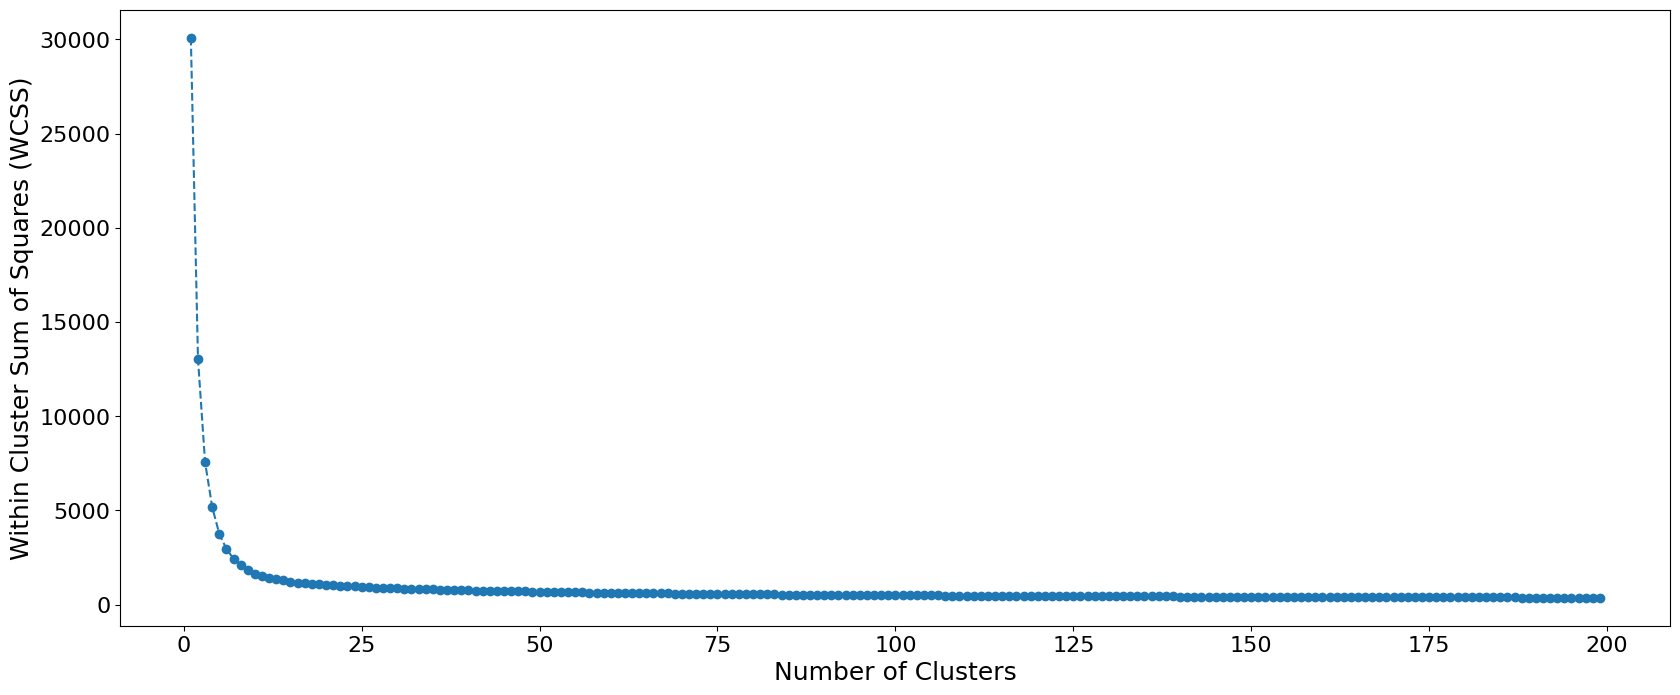

In [21]:
df.columns = df.columns.str.strip()
df.columns = df.columns.to_series().replace({r'\s+': ' ', r'_+': '_', r'—': '-'}, regex=True)

# get within cluster sum of squares for each value of k
wcss = []
max_clusters = 200
for i in range(1, max_clusters):
    kmeans_cluster = KMeans(i, init='k-means++', random_state=42)
    kmeans_cluster.fit(df[['acousticness','danceability','energy','instrumentalness','liveness','loudness','speechiness','valence']])
    wcss.append(kmeans_cluster.inertia_)
      
# programmatically locate the elbow
n_clusters = KneeLocator([i for i in range(1, max_clusters)], wcss, curve='convex', direction='decreasing').knee
print(n_clusters)
    
# visualize the curve in order to locate the elbow
fig = plt.figure(figsize=(20,8))
plt.plot(range(1, max_clusters), wcss, marker='o', linestyle='--')
# plt.vlines(n_clusters, ymin=0, ymax=max(wcss), linestyles='dashed')
plt.xlabel('Number of Clusters', fontsize=18)
plt.ylabel('Within Cluster Sum of Squares (WCSS)', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

The optimal number of clusters is determined to be **10**.

### 4.2 Applying K-Means and MinMax Scaling to Visualize

The code below initializes a KMeans clustering algorithm with a `n_clusters` number of clusters and trains it using the acoustic characteristics of the DataFrame `df`.

In [11]:
kmeans = KMeans(n_clusters=n_clusters, init='k-means++', random_state=42,)
kmeans.fit(df[['acousticness','danceability','energy','instrumentalness','liveness','loudness','speechiness','tempo','valence']])

KMeans(n_clusters=10, random_state=42)


The code below, performs feature scaling on the acoustic characteristics of the DataFrame `df`. Using a MinMaxScaler, these features are standardized to a uniform scale. Following scaling, the modified values are reassigned to the original DataFrame.

In [12]:
scaled_df = df[['acousticness','danceability','energy','instrumentalness','liveness','loudness','speechiness','tempo','valence']].copy()

scaler = MinMaxScaler() 
scaled_values = scaler.fit_transform(scaled_df) 
scaled_df.loc[:,:] = scaled_values

scaled_df['Cluster'] = kmeans.labels_

### 4.3 Visualizing the Cluster

The code below produces a radar chart via Plotly to illustrate dataset clusters. It computes the mean feature values for each cluster and displays them on the radar chart. Each cluster is depicted by a shaded region on the radar chart, with distinct colors denoting different clusters. 

The radial axis indicates the **feature value range**, while the angular axis represents **various features**.

In [13]:
fig = go.Figure()

angles = list(scaled_df[['acousticness','danceability','energy','instrumentalness','liveness','loudness','speechiness','tempo','valence']].columns)
angles.append(angles[0])

layoutdict = dict(
            radialaxis=dict(
            visible=True,
            range=[0, 1]
            ))

for i in range(n_clusters):
    subset = scaled_df[scaled_df['Cluster'] == i]
    data = [np.mean(subset[col]) for col in subset[['acousticness','danceability','energy','instrumentalness','liveness','loudness','speechiness','tempo','valence']].columns]
    data.append(data[0])
    fig.add_trace(go.Scatterpolar(
        r=data,
        theta=angles,
        fill='toself',
        name="Cluster " + str(i)))
    
fig.update_layout(
        polar=layoutdict,
        showlegend=True,template='plotly_dark'
        )
fig.show()

In [14]:
scaled_df['name'] = df['name']
scaled_df[scaled_df['Cluster'] == 5]['name']

4               Hips Don't Lie (feat. Wyclef Jean)
11      Syypää sun hymyyn (feat. Yasmine Yamajako)
28                        Thrift Shop (feat. Wanz)
35                                         Capsize
51                                    Onnelliseksi
                           ...                    
5265                                          deäm
5268             New York (feat. Ghostface Killah)
5272                                     Dark Side
5281                 Kran Turismo (feat. Raappana)
5284                                  seaside_demo
Name: name, Length: 724, dtype: object

## 5. Nearest Neighbor Algorithm

### 5.1 Data Pre-Processing for the Algorithm

The code below extracts specific columns from the DataFrame `merged_df` and `df_genre`, forming a new DataFrame named `dataset`.

The **id** column is designated as the index of the resulting DataFrame for further analysis.

In [15]:
list1=['acousticness','danceability','energy','instrumentalness','liveness','loudness','speechiness','tempo','valence']
list2=list(df_genre.columns)
dataset = merged_df[list1+list2].copy()

dataset.set_index('id',drop=True,inplace=True)

dataset.head()

,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,irish singer-songwriter,...,dreamo,modern dream pop,korean r&b,symphonic rock,indie rock italiano,italian pop,oulu metal,sped up,indie surf,surf punk
id,,,,,,,,,,,,,,,,,,,,,
7dS5EaCoMnN7DzlpT6aRn2,0.6340,0.566,0.664,0.000000,0.116,-5.303,0.0464,128.945,0.437,1,...,0,0,0,0,0,0,0,0,0,0
2V4bv1fNWfTcyRJKmej6Sj,0.1790,0.768,0.820,0.000000,0.689,-4.630,0.0474,129.965,0.625,0,...,0,0,0,0,0,0,0,0,0,0
7KA4W4McWYRpgf0fWsJZWB,0.3710,0.558,0.559,0.000007,0.109,-9.222,0.0959,78.558,0.620,0,...,0,0,0,0,0,0,0,0,0,0
3gbBpTdY8lnQwqxNCcf795,0.0755,0.679,0.715,0.000000,0.271,-6.383,0.0407,127.435,0.571,0,...,0,0,0,0,0,0,0,0,0,0
3ZFTkvIE7kyPt6Nu3PEa7V,0.2840,0.778,0.824,0.000000,0.405,-5.892,0.0707,100.024,0.758,0,...,0,0,0,0,0,0,0,0,0,0


In [16]:
dataset_matrix = csr_matrix(dataset.values)
dataset

,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,irish singer-songwriter,...,dreamo,modern dream pop,korean r&b,symphonic rock,indie rock italiano,italian pop,oulu metal,sped up,indie surf,surf punk
id,,,,,,,,,,,,,,,,,,,,,
7dS5EaCoMnN7DzlpT6aRn2,0.634000,0.566,0.664,0.000000,0.116,-5.303,0.0464,128.945,0.437,1,...,0,0,0,0,0,0,0,0,0,0
2V4bv1fNWfTcyRJKmej6Sj,0.179000,0.768,0.820,0.000000,0.689,-4.630,0.0474,129.965,0.625,0,...,0,0,0,0,0,0,0,0,0,0
7KA4W4McWYRpgf0fWsJZWB,0.371000,0.558,0.559,0.000007,0.109,-9.222,0.0959,78.558,0.620,0,...,0,0,0,0,0,0,0,0,0,0
3gbBpTdY8lnQwqxNCcf795,0.075500,0.679,0.715,0.000000,0.271,-6.383,0.0407,127.435,0.571,0,...,0,0,0,0,0,0,0,0,0,0
3ZFTkvIE7kyPt6Nu3PEa7V,0.284000,0.778,0.824,0.000000,0.405,-5.892,0.0707,100.024,0.758,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5vfjUAhefN7IjHbTvVCT4Z,0.000138,0.538,0.884,0.000000,0.466,-3.251,0.0310,146.511,0.736,0,...,0,0,0,0,0,0,0,0,0,0
0tyR7Bu9P086aWBFZ4QJoo,0.049300,0.369,0.845,0.000000,0.416,-3.449,0.0611,78.532,0.782,0,...,0,0,0,0,0,0,0,0,0,0
03j1Sho436mK0c4YqQWg1K,0.002180,0.578,0.849,0.000000,0.389,-4.614,0.0595,136.021,0.626,0,...,0,0,0,0,0,0,0,0,0,0


### 5.2 Model Fit

The code below initializes a Nearest Neighbors model `model_knn` using the brute-force algorithm for nearest neighbor search, with cosine distance as the metric. After initialization, the model is fitted to the dataset matrix `dataset_matrix`, enabling it to learn the relationships between data points based on their feature vectors.

In [17]:
model_knn = NearestNeighbors(metric='cosine', algorithm='brute')
model_knn.fit(dataset_matrix)

NearestNeighbors(algorithm='brute', metric='cosine')

## 6. Testing the Model

### 6.1 Testing the model for the Track - Take Me To Church

In [18]:
search_id = '7dS5EaCoMnN7DzlpT6aRn2'
query_index = df[df['id']==search_id].index.values[0]

distances, indices = model_knn.kneighbors(dataset.iloc[query_index,:].values.reshape(1,-1),n_neighbors=20)

for i in range(0,len(distances.flatten())):

    if i == 0:
      print('Recommendations for {0}:\n'.format(df[df['id']==str(dataset.index[query_index])]['name'].values[0]))
    else:
      print('{0} : {1} by {3}, with distance of {2}'.format(i,
                                                     df[df['id']==str(dataset.index[indices.flatten()[i]])]['name'].values[0],
                                                     distances.flatten()[i],
                                                     df[df['id']==str(dataset.index[indices.flatten()[i]])]['artist'].values[0]
                                                     ))

Recommendations for Take Me To Church:

1 : Eighteen by Pale Waves, with distance of 8.173036477943096e-05
2 : Panini by Lil Nas X, with distance of 8.711637023950392e-05
3 : Geek'd (feat. Lil Baby) by Bhad Bhabie,Lil Baby, with distance of 8.951230611531358e-05
4 : Mitä Jos by JANNA, with distance of 9.607316232307372e-05
5 : Jos Mun Pokka Pettää by Haloo Helsinki!, with distance of 0.00010194353993886462
6 : Before You Go by Lewis Capaldi, with distance of 0.00010491621865682532
7 : Shark In The Water by V V Brown, with distance of 0.00010705692859380722
8 : Malibu by Miley Cyrus, with distance of 0.00010706327163334528
9 : JUST ME by KILLBOY, with distance of 0.00011298171573292937
10 : Lifetime (feat. Kyler England) by Yellow Claw,Tiësto,Kyler England, with distance of 0.00011372473556836571
11 : BLEACH by BROCKHAMPTON, with distance of 0.00011603371761348402
12 : Hurt You by The Weeknd,Gesaffelstein, with distance of 0.00011609975835380482
13 : Retrospect by Kooma,Veela, with dist

### 6.2 Testing the model for the Track - Roses (with Juice WRLD feat. Brendon Urie)

In [19]:
search_id = '5ry2OE6R2zPQFDO85XkgRb'
query_index = df[df['id']==search_id].index.values[0]

distances, indices = model_knn.kneighbors(dataset.iloc[query_index,:].values.reshape(1,-1),n_neighbors=20)

for i in range(0,len(distances.flatten())):

    if i == 0:
      print('Recommendations for {0}:\n'.format(df[df['id']==str(dataset.index[query_index])]['name'].values[0]))
    else:
      print('{0} : {1} by {3}, with distance of {2}'.format(i,
                                                     df[df['id']==str(dataset.index[indices.flatten()[i]])]['name'].values[0],
                                                     distances.flatten()[i],
                                                     df[df['id']==str(dataset.index[indices.flatten()[i]])]['artist'].values[0]
                                                     ))

Recommendations for Roses (with Juice WRLD feat. Brendon Urie):

1 : I Know You Want Me (Calle Ocho) by Pitbull, with distance of 1.3589678377945447e-05
2 : Levottomat Tuulet by DISCO, with distance of 0.00012723559952598773
3 : WHATS POPPIN by Jack Harlow, with distance of 0.00014811032827488635
4 : Vanilla Twilight by Owl City, with distance of 0.00015222681857196552
5 : Krusty Krab by Trap City, with distance of 0.00016088823893767312
6 : Wrecking Ball by Miley Cyrus, with distance of 0.00016582539878196023
7 : Don't Matter by Akon, with distance of 0.00016803382296970426
8 : Slide Away by Miley Cyrus, with distance of 0.00016881144033520368
9 : Around the World (La La La La La) - Radio Version by A Touch Of Class,Pete Konemann, with distance of 0.0001701022290151455
10 : Summer of Love by Cascada, with distance of 0.00017114093318937318
11 : No Idea by Don Toliver, with distance of 0.0001743616938074677
12 : Mustis by JANNA,Pyhimys, with distance of 0.00017452159475983553
13 : Kale

### 6.3 Testing the model for the Track - Make Believe

In [20]:
search_id = '3QXGTfSo23CBfI0KShmIm3'
query_index = df[df['id']==search_id].index.values[0]

distances, indices = model_knn.kneighbors(dataset.iloc[query_index,:].values.reshape(1,-1),n_neighbors=20)

for i in range(0,len(distances.flatten())):

    if i == 0:
      print('Recommendations for {0}:\n'.format(df[df['id']==str(dataset.index[query_index])]['name'].values[0]))
    else:
      print('{0} : {1} by {3}, with distance of {2}'.format(i,
                                                     df[df['id']==str(dataset.index[indices.flatten()[i]])]['name'].values[0],
                                                     distances.flatten()[i],
                                                     df[df['id']==str(dataset.index[indices.flatten()[i]])]['artist'].values[0]
                                                     ))

Recommendations for Make Believe:

1 : Freaky Like Me by Madcon,Ameerah, with distance of 4.018700718089185e-06
2 : Mehu by TIPPA, with distance of 1.0284375166813575e-05
3 : In Your Eyes by The Weeknd, with distance of 1.1970570108044143e-05
4 : Aamukuuteen (feat. Erin) by Antti Tuisku,Erin, with distance of 1.598621000742373e-05
5 : Jäätyy by Lucas, with distance of 1.7539555706602705e-05
6 : Say It Right - Main by Nelly Furtado, with distance of 1.8523695699990128e-05
7 : Passenger by Britney Spears, with distance of 1.8617958127298273e-05
8 : Let Go by Redrama,Kristinia DeBarge, with distance of 1.8618258655678233e-05
9 : 1985 by Tuomas Kauhanen, with distance of 1.883617487730138e-05
10 : Ghost Town by Kanye West,PARTYNEXTDOOR, with distance of 1.9902552567119258e-05
11 : Sweet Home Alabama by The Outlaws,Hughie Thomasson, with distance of 1.992790164839775e-05
12 : Stay (with Alessia Cara) by Zedd,Alessia Cara, with distance of 2.0724913021630265e-05
13 : I Will Be There by Britn

## 7. Conclusion

The project aimed to construct a Music Recommendation System utilizing the Nearest Neighbor algorithm and content-based filtering. Through a neighborhood-based approach with cosine similarity, tracks were quantified based on similarities in audio features. This facilitated the implementation of the Nearest Neighbor algorithm, which in turn generated personalized track recommendations. 

While the model showed promise in testing, further refinement, such as incorporating more diverse songs and refining genre classification, could enhance its accuracy and effectiveness, providing users with a more enriching music discovery experience.